## PS3, Question 1: Decision Tree

The first block of code contains my version of the decision tree algorithm. It uses information gain as the splitting criteria and only allows for binary splits. When applied to the Iris dataset and using a maximum depth of 4 nodes, my algorithm produced a training accuracy of 100% and test accuracy of 96% perhaps suggesting some overfitting.

The second block of code contains the implementation of sklearn's DecisionTreeClassifier. I specified entropy as the splitting criteria and again utilized a maximum depth of 4 nodes. When fit to the iris dataset, a training accuracy of 100% and test accuracy of 98% was obtained.

Overall, results are very similar. Illustrations of both trees can be found below.

In [28]:
import math
import numpy as np
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def load_dataset():
    ''' load iris dataset '''
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    
    return X, y

def build_tree(train, max_depth, min_size):
    ''' build the decision tree thru recursion '''
    
    # get the first split
    root = get_split(train)
    
    # then actually split the tree and recurse
    split(root, max_depth, min_size, 1)
    
    return root

def get_split(dataset):
    ''' find the best split point using information gain '''
    
    # get class values
    class_values = list(set(row[-1] for row in dataset))
    
    # initialize values
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    
    # for each attribute and row
    for index in range(len(dataset[0])-1):
        for row in dataset:
            
            # split samples into left and right groups based on attribute/row value
            groups = test_split(index, row[index], dataset)
            
            # calculate information gain
            ig = information_gain(groups, class_values)
            
            # if ig is lower than current saved value, replace it
            if ig < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], ig, groups
    
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

def test_split(index, value, dataset):
    ''' split data into left and right nodes based on a value '''
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def information_gain(groups, classes):
    ''' calculate the information gain for a specific split '''
    
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    
    # initialize
    ig = 0.0
    
    # for left and right nodes
    for group in groups:
        
        # get number of samples in node
        size = float(len(group))
        
        # avoid divide by zero
        if size == 0:
            continue
        
        # initialize
        score = 0.0
        
        # score the group based on the score for each class
        for class_val in classes: 
            
            # calculate freq of class
            p = [row[-1] for row in group].count(class_val) / size # count number of samples that belong to class and divide by total samples in group
            
            # check that we don't take log of 0
            if p == 0:
                score += 0
            else:
                score += -p * math.log(p,2)
        
        # weight the score by its relative size
        ig += score * (size / n_instances)
    return ig

def split(node, max_depth, min_size, depth):
    ''' continue spliting nodes through recursion or make it a terminal node '''
    
    left, right = node['groups']
    del(node['groups'])
    
    # check for an empty node
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    
    # process left child node
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    
    # process right child node
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def to_terminal(group):
    ''' assign value to terminal node '''
    
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def predict(node, row):
    ''' make a prediction by recursing down the tree '''
    
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
def print_tree(node, depth=0):
    ''' print the decision tree '''
    
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (iris.feature_names[node['index']]), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# ============================================================================================
        
# params
max_depth = 4
min_size = 2

# load dataset
X, y = load_dataset()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  
    
# prep training set
train = np.column_stack((X_train,y_train))
train_set = list(train)
    
# prep test set
test = np.column_stack((X_test,y_test))
test_set = list(test)
        
print('train samples: ', len(train_set))
print('test samples: ', len(test_set))
print()

# build decision tree using information gain
tree = build_tree(train_set, max_depth, min_size)

# output training accuracy
train_predictions = list()
for row in train_set:
    prediction = predict(tree, row)
    train_predictions.append(prediction)
train_actual = [row[-1] for row in train_set]
accuracy = accuracy_score(train_actual, train_predictions)
print('train accuracy: ', accuracy)

# output test accuracy
test_predictions = list()
for row in test_set:
    prediction = predict(tree, row)
    test_predictions.append(prediction)
test_actual = [row[-1] for row in test_set]
accuracy = accuracy_score(test_actual, test_predictions)
print('test accuracy: ', accuracy)

# print the tree
print()
print_tree(tree)

train samples:  105
test samples:  45

train accuracy:  1.0
test accuracy:  0.9555555555555556

[petal length (cm) < 3.300]
 [sepal length (cm) < 4.500]
  [sepal length (cm) < 4.300]
   [0.0]
   [0.0]
  [sepal length (cm) < 4.500]
   [0.0]
   [0.0]
 [petal width (cm) < 1.800]
  [petal length (cm) < 5.000]
   [petal width (cm) < 1.700]
    [1.0]
    [2.0]
   [petal width (cm) < 1.700]
    [2.0]
    [1.0]
  [petal length (cm) < 4.900]
   [sepal length (cm) < 6.000]
    [1.0]
    [2.0]
   [sepal length (cm) < 5.900]
    [2.0]
    [2.0]


Training set accuracy: 1.0000
Test set accuracy: 0.9778


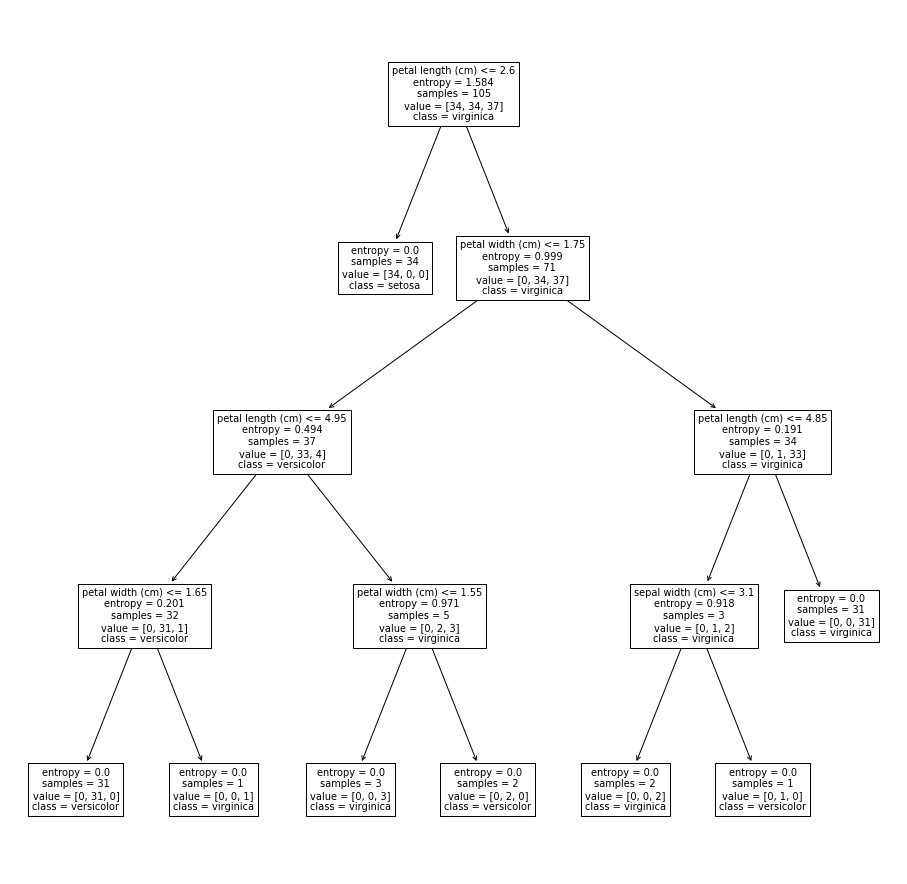

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# load dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fit classifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(X_train, y_train)

# print training and test set accuracy
print(f'Training set accuracy: {clf.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {clf.score(X_test, y_test):.4f}')

# plot tree
plt.figure(figsize=(16,16))
plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()